In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from pprint import pprint
%matplotlib inline

In [2]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [3]:
from keras.models import Sequential
from keras.layers import Activation, Dense, LeakyReLU, Dropout, BatchNormalization
from keras.losses import mean_squared_error, binary_crossentropy
from keras.optimizers import Adam, RMSprop
from keras import metrics
from keras import regularizers

Using TensorFlow backend.


In [4]:
start = datetime(2000,1,1)
end = datetime(2017,1,1)
ticker = 'MSFT'
max_shift = 30
return_shift_days = -5

In [5]:
original_data = pdr.get_data_yahoo(ticker, start, end)
original_data.drop(['Volume', 'Adj Close'], axis=1, inplace=True)

In [6]:
def to_datetime(x):
    return np.array(x, dtype=np.datetime64)

p1 = figure(x_axis_type="datetime", title="{} Closing Prices".format(ticker))
p1.grid.grid_line_alpha=0.3
p1.xaxis.axis_label = 'Date'
p1.yaxis.axis_label = 'Price'

p1.line(to_datetime(original_data.index), original_data['Close'], legend=ticker)
show(p1)

In [7]:
# original_data.to_pickle('SPY.pkl')

In [8]:
# original_data = pd.read_pickle('SPY.pkl')

In [9]:
original_data.head()

,Open,High,Low,Close
Date,,,,
1999-12-31,58.75000,58.8750,58.1250,58.37500
2000-01-03,58.68750,59.3125,56.0000,58.28125
2000-01-04,56.78125,58.5625,56.1250,56.31250
2000-01-05,55.56250,58.1875,54.6875,56.90625
2000-01-06,56.09375,56.9375,54.1875,55.00000


### Create data representation

In [10]:
data = original_data.copy()
data.columns = pd.MultiIndex.from_product([['Shift 0'],['Open','High','Low','Close']])
for i in range(1, max_shift + 1):
    shifted = data.iloc[:,[0,1,2,3]].shift(i)
    shifted.columns = pd.MultiIndex.from_product([['Shift ' + str(i)],['Open','High','Low','Close']])
    data = pd.concat([data, shifted], axis=1)

In [11]:
data.head(6)

Shift 0                                Shift 1                    \
                Open     High       Low     Close      Open     High      Low   
Date                                                                            
1999-12-31  58.75000  58.8750  58.12500  58.37500       NaN      NaN      NaN   
2000-01-03  58.68750  59.3125  56.00000  58.28125  58.75000  58.8750  58.1250   
2000-01-04  56.78125  58.5625  56.12500  56.31250  58.68750  59.3125  56.0000   
2000-01-05  55.56250  58.1875  54.68750  56.90625  56.78125  58.5625  56.1250   
2000-01-06  56.09375  56.9375  54.18750  55.00000  55.56250  58.1875  54.6875   
2000-01-07  54.31250  56.1250  53.65625  55.71875  56.09375  56.9375  54.1875   

                       Shift 2           ...  Shift 28       Shift 29       \
               Close      Open     High  ...       Low Close     Open High   
Date                                     ...                                 
1999-12-31       NaN       NaN      NaN  ...       NaN   NaN      NaN  NaN   
2000-01-03  58.37500       NaN      NaN  ...       NaN   NaN      NaN  NaN   
2000-01-04  58.28125  58.75000  58.8750  ...       NaN   NaN      NaN  NaN   
2000-01-05  56.31250  58.68750  59.3125  ...       NaN   NaN      NaN  NaN   
2000-01-06  56.90625  56.78125  58.5625  ...       NaN   NaN      NaN  NaN   
2000-01-07  55.00000  55.56250  58.1875  ...       NaN   NaN      NaN  NaN   

                     Shift 30                 
           Low Close     Open High Low Close  
Date                                          
1999-12-31 NaN   NaN      NaN  NaN NaN   NaN  
2000-01-03 NaN   NaN      NaN  NaN NaN   NaN  
2000-01-04 NaN   NaN      NaN  NaN NaN   NaN  
2000-01-05 NaN   NaN      NaN  NaN NaN   NaN  
2000-01-06 NaN   NaN      NaN  NaN NaN   NaN  
2000-01-07 NaN   NaN      NaN  NaN NaN   NaN  

[6 rows x 124 columns]

In [12]:
data['Shift 2', 'Close'].head(3)

Date
1999-12-31       NaN
2000-01-03       NaN
2000-01-04    58.375
Name: (Shift 2, Close), dtype: float64

In [13]:
for i in range(0, max_shift):
    cls = data['Shift ' + str(i), 'Close']
    opn = data['Shift ' + str(i), 'Open']
    data['Shift ' + str(i), 'Bull ' + str(i)] = 100 * (cls - opn) / cls

In [14]:
data['Shift 0'].head(2)

,Open,High,Low,Close,Bull 0
Date,,,,,
1999-12-31,58.7500,58.8750,58.125,58.37500,-0.642398
2000-01-03,58.6875,59.3125,56.000,58.28125,-0.697051


In [15]:
for i in range(0, max_shift):
    opn = data['Shift ' + str(i), 'Open']
    prv_cls = data['Shift ' + str(i+1), 'Close']
    data['Shift ' + str(i), 'GT ' + str(i)] = 100 * (opn - prv_cls) / opn

In [16]:
data[['Shift 0', 'Shift 1']].head()

Shift 0                                                  \
                Open     High      Low     Close    Bull 0      GT 0   
Date                                                                   
1999-12-31  58.75000  58.8750  58.1250  58.37500 -0.642398       NaN   
2000-01-03  58.68750  59.3125  56.0000  58.28125 -0.697051  0.532481   
2000-01-04  56.78125  58.5625  56.1250  56.31250 -0.832408 -2.641717   
2000-01-05  55.56250  58.1875  54.6875  56.90625  2.361340 -1.349831   
2000-01-06  56.09375  56.9375  54.1875  55.00000 -1.988636 -1.448468   

             Shift 1                                                  
                Open     High      Low     Close    Bull 1      GT 1  
Date                                                                  
1999-12-31       NaN      NaN      NaN       NaN       NaN       NaN  
2000-01-03  58.75000  58.8750  58.1250  58.37500 -0.642398       NaN  
2000-01-04  58.68750  59.3125  56.0000  58.28125 -0.697051  0.532481  
2000-01-05  56.78125  58.5625  56.1250  56.31250 -0.832408 -2.641717  
2000-01-06  55.56250  58.1875  54.6875  56.90625  2.361340 -1.349831

In [17]:
shifted = data.iloc[:,[0,1,2,3]].shift(return_shift_days)
shifted.columns = pd.MultiIndex.from_product([['Shift -5'],['Open','High','Low','Close']])
data = pd.concat([data, shifted], axis=1)

In [18]:
cls_5 = data['Shift -5', 'Close']
cls = data['Shift 0', 'Close']
data['Shift 0', 'Return'] = 100 * (cls_5 - cls) / cls_5
data.head()

Shift 0                               Shift 1                    \
                Open     High      Low     Close      Open     High      Low   
Date                                                                           
1999-12-31  58.75000  58.8750  58.1250  58.37500       NaN      NaN      NaN   
2000-01-03  58.68750  59.3125  56.0000  58.28125  58.75000  58.8750  58.1250   
2000-01-04  56.78125  58.5625  56.1250  56.31250  58.68750  59.3125  56.0000   
2000-01-05  55.56250  58.1875  54.6875  56.90625  56.78125  58.5625  56.1250   
2000-01-06  56.09375  56.9375  54.1875  55.00000  55.56250  58.1875  54.6875   

                       Shift 2             ...    Shift 25 Shift 26 Shift 27  \
               Close      Open     High    ...       GT 25    GT 26    GT 27   
Date                                       ...                                 
1999-12-31       NaN       NaN      NaN    ...         NaN      NaN      NaN   
2000-01-03  58.37500       NaN      NaN    ...         NaN      NaN      NaN   
2000-01-04  58.28125  58.75000  58.8750    ...         NaN      NaN      NaN   
2000-01-05  56.31250  58.68750  59.3125    ...         NaN      NaN      NaN   
2000-01-06  56.90625  56.78125  58.5625    ...         NaN      NaN      NaN   

           Shift 28 Shift 29  Shift -5                                 Shift 0  
              GT 28    GT 29      Open      High       Low     Close    Return  
Date                                                                            
1999-12-31      NaN      NaN  54.31250  56.12500  53.65625  55.71875 -4.767246  
2000-01-03      NaN      NaN  56.71875  56.84375  55.68750  56.12500 -3.841871  
2000-01-04      NaN      NaN  55.75000  57.12500  54.34375  54.68750 -2.971429  
2000-01-05      NaN      NaN  54.25000  54.43750  52.21875  52.90625 -7.560543  
2000-01-06      NaN      NaN  52.18750  54.31250  50.75000  53.90625 -2.028986  

[5 rows x 189 columns]

In [19]:
binary_data = data.drop(['Open', 'High', 'Low', 'Close'], axis=1, level=1)
binary_data.head()

,Shift 0,Shift 1,Shift 2,Shift 3,Shift 4,Shift 5,Shift 6,Shift 7,Shift 8,Shift 9,...,Shift 21,Shift 22,Shift 23,Shift 24,Shift 25,Shift 26,Shift 27,Shift 28,Shift 29,Shift 0
,Bull 0,Bull 1,Bull 2,Bull 3,Bull 4,Bull 5,Bull 6,Bull 7,Bull 8,Bull 9,...,GT 21,GT 22,GT 23,GT 24,GT 25,GT 26,GT 27,GT 28,GT 29,Return
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,-0.642398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.767246
2000-01-03,-0.697051,-0.642398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.841871
2000-01-04,-0.832408,-0.697051,-0.642398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.971429
2000-01-05,2.361340,-0.832408,-0.697051,-0.642398,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.560543
2000-01-06,-1.988636,2.361340,-0.832408,-0.697051,-0.642398,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.028986


In [20]:
binary_data.columns = binary_data.columns.droplevel()

In [21]:
binary_data.head(10)

,Bull 0,Bull 1,Bull 2,Bull 3,Bull 4,Bull 5,Bull 6,Bull 7,Bull 8,Bull 9,...,GT 21,GT 22,GT 23,GT 24,GT 25,GT 26,GT 27,GT 28,GT 29,Return
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,-0.642398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.767246
2000-01-03,-0.697051,-0.642398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.841871
2000-01-04,-0.832408,-0.697051,-0.642398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.971429
2000-01-05,2.361340,-0.832408,-0.697051,-0.642398,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.560543
2000-01-06,-1.988636,2.361340,-0.832408,-0.697051,-0.642398,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.028986
2000-01-07,2.523836,-1.988636,2.361340,-0.832408,-0.697051,-0.642398,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.723831
2000-01-10,-1.057906,2.523836,-1.988636,2.361340,-0.832408,-0.697051,-0.642398,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.655827
2000-01-11,-1.942857,-1.057906,2.523836,-1.988636,2.361340,-0.832408,-0.697051,-0.642398,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.219626
2000-01-12,-2.539870,-1.942857,-1.057906,2.523836,-1.988636,2.361340,-0.832408,-0.697051,-0.642398,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.176887


# Train Keras NN

### Setup X_train, X_test, etc

In [22]:
binary_data.dropna(inplace=True)

In [23]:
X = binary_data.drop('Return', axis=1)
y = binary_data['Return'] > 0
y = np.expand_dims(y, axis=1)
y = np.hstack((y, 1 - y))

In [24]:
returns = binary_data['Return']
returns.head(10)

Date
2000-02-14   -6.195869
2000-02-15   -4.575597
2000-02-16   -3.034301
2000-02-17   -9.103354
2000-02-18   -3.822526
2000-02-22   -4.965035
2000-02-23   -3.785272
2000-02-24   -1.472557
2000-02-25    5.006502
2000-02-28   -1.034483
Name: Return, dtype: float64

In [25]:
y[0:10]

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1]])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
print('Full data size: ', binary_data.shape[0], ' rows')
print('Train data size: ', X_train.shape[0], ' rows')

Full data size:  4243  rows
Train data size:  3394  rows


### Build model

In [29]:
model = Sequential()
model.add(Dense(max_shift*7, input_dim=X.shape[1], kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(max_shift*6, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(max_shift*5, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(max_shift*4, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(max_shift*3, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(2, kernel_initializer='uniform'))
model.add(Activation('softmax'))

model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=700, 
          batch_size=256, 
          verbose=2)

Train on 3394 samples, validate on 849 samples
Epoch 1/700
3s - loss: 0.7048 - acc: 0.5127 - val_loss: 0.6940 - val_acc: 0.4287
Epoch 2/700
0s - loss: 0.7006 - acc: 0.5082 - val_loss: 0.6927 - val_acc: 0.5713
Epoch 3/700
0s - loss: 0.6937 - acc: 0.5268 - val_loss: 0.6929 - val_acc: 0.5713
Epoch 4/700
0s - loss: 0.6992 - acc: 0.5094 - val_loss: 0.6927 - val_acc: 0.5713
Epoch 5/700
0s - loss: 0.6948 - acc: 0.5230 - val_loss: 0.6921 - val_acc: 0.5713
Epoch 6/700
0s - loss: 0.6943 - acc: 0.5153 - val_loss: 0.6914 - val_acc: 0.5713
Epoch 7/700
0s - loss: 0.6921 - acc: 0.5301 - val_loss: 0.6902 - val_acc: 0.5713
Epoch 8/700
0s - loss: 0.6901 - acc: 0.5321 - val_loss: 0.6889 - val_acc: 0.5713
Epoch 9/700
0s - loss: 0.6928 - acc: 0.5268 - val_loss: 0.6880 - val_acc: 0.5713
Epoch 10/700
0s - loss: 0.6918 - acc: 0.5189 - val_loss: 0.6888 - val_acc: 0.5713
Epoch 11/700
0s - loss: 0.6913 - acc: 0.5277 - val_loss: 0.6879 - val_acc: 0.5713
Epoch 12/700
0s - loss: 0.6916 - acc: 0.5239 - val_loss: 0.6

0s - loss: 0.4466 - acc: 0.7982 - val_loss: 0.8910 - val_acc: 0.5642
Epoch 102/700
0s - loss: 0.4367 - acc: 0.7970 - val_loss: 0.8949 - val_acc: 0.5548
Epoch 103/700
0s - loss: 0.4323 - acc: 0.8014 - val_loss: 0.9121 - val_acc: 0.5654
Epoch 104/700
0s - loss: 0.4274 - acc: 0.8079 - val_loss: 0.9299 - val_acc: 0.5501
Epoch 105/700
0s - loss: 0.4332 - acc: 0.8049 - val_loss: 0.9157 - val_acc: 0.5524
Epoch 106/700
0s - loss: 0.4087 - acc: 0.8206 - val_loss: 0.8961 - val_acc: 0.5665
Epoch 107/700
0s - loss: 0.4279 - acc: 0.8011 - val_loss: 0.9290 - val_acc: 0.5548
Epoch 108/700
0s - loss: 0.4181 - acc: 0.8144 - val_loss: 0.9402 - val_acc: 0.5736
Epoch 109/700
0s - loss: 0.4259 - acc: 0.8079 - val_loss: 0.9683 - val_acc: 0.5630
Epoch 110/700
0s - loss: 0.4376 - acc: 0.8017 - val_loss: 0.9100 - val_acc: 0.5583
Epoch 111/700
0s - loss: 0.4161 - acc: 0.8123 - val_loss: 0.9103 - val_acc: 0.5724
Epoch 112/700
0s - loss: 0.4312 - acc: 0.8064 - val_loss: 0.9084 - val_acc: 0.5701
Epoch 113/700
0s -

0s - loss: 0.3082 - acc: 0.8745 - val_loss: 1.1877 - val_acc: 0.5465
Epoch 201/700
0s - loss: 0.2948 - acc: 0.8780 - val_loss: 1.1974 - val_acc: 0.5536
Epoch 202/700
0s - loss: 0.3008 - acc: 0.8718 - val_loss: 1.2103 - val_acc: 0.5489
Epoch 203/700
0s - loss: 0.2972 - acc: 0.8777 - val_loss: 1.1704 - val_acc: 0.5512
Epoch 204/700
0s - loss: 0.2793 - acc: 0.8877 - val_loss: 1.2144 - val_acc: 0.5501
Epoch 205/700
0s - loss: 0.2973 - acc: 0.8745 - val_loss: 1.2036 - val_acc: 0.5630
Epoch 206/700
0s - loss: 0.3096 - acc: 0.8739 - val_loss: 1.1892 - val_acc: 0.5642
Epoch 207/700
0s - loss: 0.3013 - acc: 0.8783 - val_loss: 1.1632 - val_acc: 0.5630
Epoch 208/700
0s - loss: 0.2911 - acc: 0.8745 - val_loss: 1.1982 - val_acc: 0.5607
Epoch 209/700
0s - loss: 0.3107 - acc: 0.8704 - val_loss: 1.2049 - val_acc: 0.5583
Epoch 210/700
0s - loss: 0.2844 - acc: 0.8880 - val_loss: 1.2165 - val_acc: 0.5536
Epoch 211/700
0s - loss: 0.2874 - acc: 0.8833 - val_loss: 1.2073 - val_acc: 0.5489
Epoch 212/700
0s -

0s - loss: 0.2530 - acc: 0.9031 - val_loss: 1.2193 - val_acc: 0.5630
Epoch 300/700
0s - loss: 0.2515 - acc: 0.8981 - val_loss: 1.2374 - val_acc: 0.5689
Epoch 301/700
0s - loss: 0.2283 - acc: 0.9069 - val_loss: 1.2764 - val_acc: 0.5654
Epoch 302/700
0s - loss: 0.2413 - acc: 0.9066 - val_loss: 1.2928 - val_acc: 0.5642
Epoch 303/700
0s - loss: 0.2519 - acc: 0.8963 - val_loss: 1.2795 - val_acc: 0.5595
Epoch 304/700
0s - loss: 0.2390 - acc: 0.9087 - val_loss: 1.2919 - val_acc: 0.5642
Epoch 305/700
0s - loss: 0.2455 - acc: 0.9022 - val_loss: 1.2607 - val_acc: 0.5665
Epoch 306/700
0s - loss: 0.2499 - acc: 0.9101 - val_loss: 1.2462 - val_acc: 0.5642
Epoch 307/700
0s - loss: 0.2326 - acc: 0.9060 - val_loss: 1.2870 - val_acc: 0.5665
Epoch 308/700
0s - loss: 0.2134 - acc: 0.9093 - val_loss: 1.3435 - val_acc: 0.5677
Epoch 309/700
0s - loss: 0.2412 - acc: 0.9010 - val_loss: 1.3544 - val_acc: 0.5642
Epoch 310/700
0s - loss: 0.2348 - acc: 0.9072 - val_loss: 1.3413 - val_acc: 0.5654
Epoch 311/700
0s -

0s - loss: 0.2082 - acc: 0.9172 - val_loss: 1.3332 - val_acc: 0.5701
Epoch 399/700
0s - loss: 0.2117 - acc: 0.9204 - val_loss: 1.3222 - val_acc: 0.5654
Epoch 400/700
0s - loss: 0.2204 - acc: 0.9184 - val_loss: 1.3353 - val_acc: 0.5642
Epoch 401/700
0s - loss: 0.2034 - acc: 0.9199 - val_loss: 1.3284 - val_acc: 0.5618
Epoch 402/700
0s - loss: 0.2243 - acc: 0.9196 - val_loss: 1.2834 - val_acc: 0.5583
Epoch 403/700
0s - loss: 0.2061 - acc: 0.9231 - val_loss: 1.3229 - val_acc: 0.5618
Epoch 404/700
0s - loss: 0.2126 - acc: 0.9163 - val_loss: 1.3414 - val_acc: 0.5630
Epoch 405/700
0s - loss: 0.1910 - acc: 0.9284 - val_loss: 1.3655 - val_acc: 0.5665
Epoch 406/700
0s - loss: 0.1965 - acc: 0.9269 - val_loss: 1.3475 - val_acc: 0.5654
Epoch 407/700
0s - loss: 0.2190 - acc: 0.9163 - val_loss: 1.3705 - val_acc: 0.5618
Epoch 408/700
0s - loss: 0.2081 - acc: 0.9151 - val_loss: 1.3281 - val_acc: 0.5607
Epoch 409/700
0s - loss: 0.2247 - acc: 0.9104 - val_loss: 1.3263 - val_acc: 0.5654
Epoch 410/700
0s -

0s - loss: 0.1790 - acc: 0.9328 - val_loss: 1.3801 - val_acc: 0.5595
Epoch 498/700
0s - loss: 0.2031 - acc: 0.9207 - val_loss: 1.4015 - val_acc: 0.5571
Epoch 499/700
0s - loss: 0.1913 - acc: 0.9299 - val_loss: 1.4046 - val_acc: 0.5595
Epoch 500/700
0s - loss: 0.1968 - acc: 0.9222 - val_loss: 1.3819 - val_acc: 0.5618
Epoch 501/700
0s - loss: 0.1933 - acc: 0.9275 - val_loss: 1.3659 - val_acc: 0.5724
Epoch 502/700
0s - loss: 0.1947 - acc: 0.9281 - val_loss: 1.3749 - val_acc: 0.5677
Epoch 503/700
0s - loss: 0.2007 - acc: 0.9266 - val_loss: 1.3710 - val_acc: 0.5654
Epoch 504/700
0s - loss: 0.1977 - acc: 0.9246 - val_loss: 1.3448 - val_acc: 0.5665
Epoch 505/700
0s - loss: 0.1911 - acc: 0.9287 - val_loss: 1.3473 - val_acc: 0.5665
Epoch 506/700
0s - loss: 0.1945 - acc: 0.9299 - val_loss: 1.3660 - val_acc: 0.5665
Epoch 507/700
0s - loss: 0.1900 - acc: 0.9252 - val_loss: 1.3629 - val_acc: 0.5665
Epoch 508/700
0s - loss: 0.2141 - acc: 0.9157 - val_loss: 1.3079 - val_acc: 0.5642
Epoch 509/700
0s -

0s - loss: 0.1908 - acc: 0.9255 - val_loss: 1.3817 - val_acc: 0.5642
Epoch 597/700
0s - loss: 0.1968 - acc: 0.9263 - val_loss: 1.3665 - val_acc: 0.5654
Epoch 598/700
0s - loss: 0.1805 - acc: 0.9299 - val_loss: 1.3365 - val_acc: 0.5618
Epoch 599/700
0s - loss: 0.1878 - acc: 0.9311 - val_loss: 1.3701 - val_acc: 0.5595
Epoch 600/700
0s - loss: 0.1818 - acc: 0.9308 - val_loss: 1.4022 - val_acc: 0.5583
Epoch 601/700
0s - loss: 0.1573 - acc: 0.9408 - val_loss: 1.3987 - val_acc: 0.5607
Epoch 602/700
0s - loss: 0.1796 - acc: 0.9305 - val_loss: 1.4137 - val_acc: 0.5583
Epoch 603/700
0s - loss: 0.1900 - acc: 0.9290 - val_loss: 1.4200 - val_acc: 0.5630
Epoch 604/700
0s - loss: 0.1833 - acc: 0.9293 - val_loss: 1.4007 - val_acc: 0.5654
Epoch 605/700
0s - loss: 0.1834 - acc: 0.9305 - val_loss: 1.3832 - val_acc: 0.5701
Epoch 606/700
0s - loss: 0.1890 - acc: 0.9272 - val_loss: 1.3845 - val_acc: 0.5665
Epoch 607/700
0s - loss: 0.2004 - acc: 0.9222 - val_loss: 1.3818 - val_acc: 0.5630
Epoch 608/700
0s -

0s - loss: 0.1767 - acc: 0.9337 - val_loss: 1.4779 - val_acc: 0.5559
Epoch 696/700
0s - loss: 0.1686 - acc: 0.9337 - val_loss: 1.4657 - val_acc: 0.5453
Epoch 697/700
0s - loss: 0.1813 - acc: 0.9325 - val_loss: 1.4891 - val_acc: 0.5559
Epoch 698/700
0s - loss: 0.1796 - acc: 0.9278 - val_loss: 1.4921 - val_acc: 0.5618
Epoch 699/700
0s - loss: 0.1679 - acc: 0.9375 - val_loss: 1.4678 - val_acc: 0.5571
Epoch 700/700
0s - loss: 0.1848 - acc: 0.9343 - val_loss: 1.4218 - val_acc: 0.5607


In [31]:
predicted = model.predict(X_test)

In [32]:
model.evaluate(X_test, y_test)

544/849 [==================>...........] - ETA: 0s

[1.4217606885413538, 0.56065959980968028]

In [52]:
predicted[0:3].max()

0.91932601

### Handle predictions

In [61]:
certainty_percentage = predicted.max()*0.999
print('Certainty is', certainty_percentage, '%')
predicted_ups = predicted[:,0] > certainty_percentage
predicted_downs = predicted[:,1] > certainty_percentage

real_ups = y_test[:,0] == 1
real_downs = y_test[:,1] == 1

Certainty is 0.997806360126 %


### Visualize returns

In [62]:
test_returns = returns.iloc[X_train.shape[0]:]
print('Test period from {} to {}'.format(test_returns.index[0], test_returns.index[-1]))

Test period from 2013-08-13 00:00:00 to 2016-12-22 00:00:00


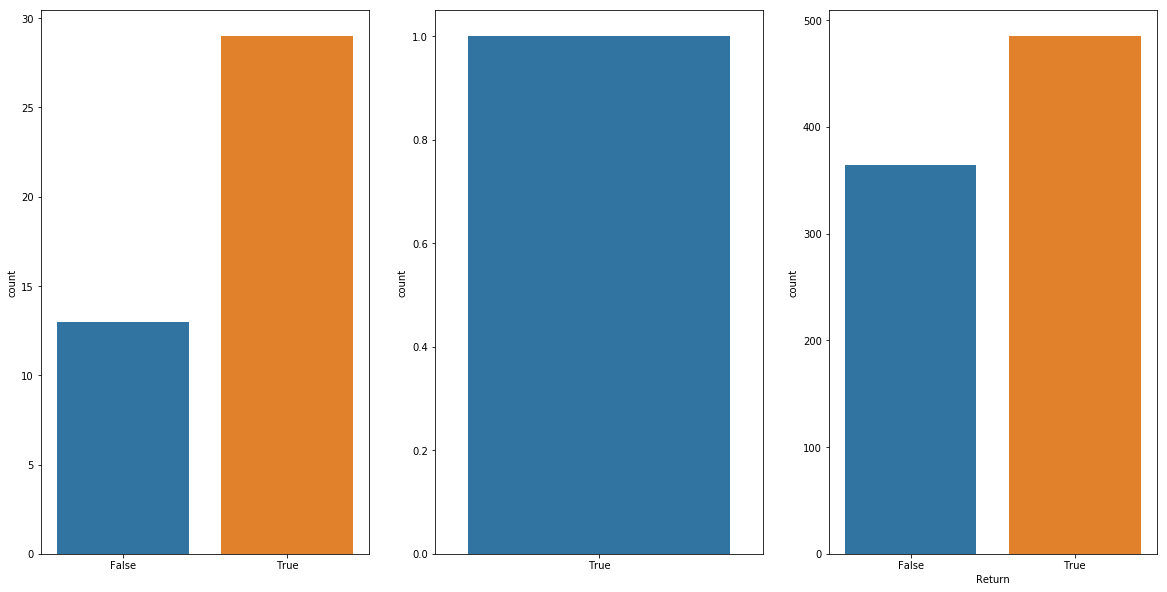

In [63]:
fig, axs = plt.subplots(ncols=3, figsize=(20,10))

if predicted_ups.any():
    sns.countplot(real_ups[predicted_ups], ax=axs[0])
if predicted_downs.any():
    sns.countplot(real_downs[predicted_downs], ax=axs[1])
    
sns.countplot(test_returns > 0, ax=axs[2])

In [64]:
def print_returns_distribution(returns):
    neg = np.sum(returns[returns < 0])
    pos = np.sum(returns[returns > 0])
    print('Negative returns: ', neg)
    print('Positive returns: ', pos)
    print('Pos/Neg ratio: ', pos/(neg*-1))
    print('Sum of returns: ', np.sum(returns))

In [65]:
real_returns = test_returns[predicted_ups].append(-1 * test_returns[predicted_downs])

In [66]:
print_returns_distribution(real_returns)

Negative returns:  -27.627187141588593
Positive returns:  67.65293850244785
Pos/Neg ratio:  2.4487812731614103
Sum of returns:  40.02575136085928


In [67]:
print_returns_distribution(test_returns)

Negative returns:  -854.412831933444
Positive returns:  1147.942732671103
Pos/Neg ratio:  1.3435457541917208
Sum of returns:  293.5299007376599


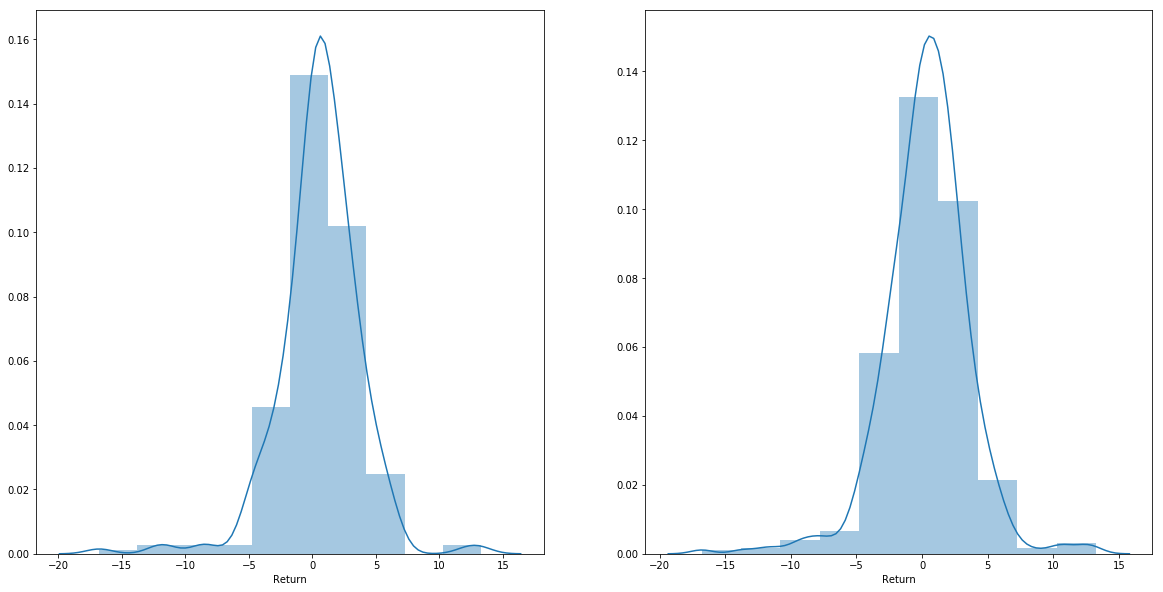

In [50]:
fig, axs = plt.subplots(ncols=2, figsize=(20,10))

sns.distplot(real_returns, bins=10, ax=axs[0])
sns.distplot(test_returns, bins=10, ax=axs[1])